In [2]:
from __future__ import annotations
import math
import numpy as np
from pathlib import Path
from contextlib import contextmanager
from typing import Tuple
import cv2

from lsst.daf.butler import Butler
import lsst.geom as geom

# ---------- small utils ----------
def ensure_dir(p: str | Path):
    Path(p).mkdir(parents=True, exist_ok=True)

@contextmanager
def suppress_stdout():
    import sys, io
    old = sys.stdout
    try:
        sys.stdout = io.StringIO()
        yield
    finally:
        sys.stdout = old

# ---------- sky-motion geometry ----------
def vsky_and_pa(ra_rate_cosdec_deg_day: float, dec_rate_deg_day: float) -> Tuple[float, float]:
    """
    Inputs are Sorcha-like components (east=x, north=y) in deg/day.
    Returns:
      vsky_deg_day, position angle in degrees East of North.
    """
    x = float(ra_rate_cosdec_deg_day)
    y = float(dec_rate_deg_day)
    vsky = math.hypot(x, y)
    pa = (math.degrees(math.atan2(x, y)) + 360.0) % 360.0
    return vsky, pa

def detectors_covering_point(butler: Butler, visit: int, ra_deg: float, dec_deg: float):
    where = (
        f"instrument='LSSTCam' AND visit={int(visit)} "
        f"AND visit_detector_region.region OVERLAPS POINT({ra_deg:.9f}, {dec_deg:.9f})"
    )
    return list(butler.registry.queryDatasets("calexp", where=where, findFirst=True))

def sky_to_pixel(calexp, ra_deg: float, dec_deg: float) -> Tuple[float, float]:
    sp = geom.SpherePoint(geom.Angle(ra_deg, geom.degrees), geom.Angle(dec_deg, geom.degrees))
    x, y = calexp.wcs.skyToPixel(sp)
    return float(x), float(y)

def draw_one_line(mask, origin, angle, length, true_value=1, line_thickness=500):
    x0, y0 = origin
    x_size = length * np.cos((np.pi / 180) * angle)
    y_size = length * np.sin((np.pi / 180) * angle)
    x1 = x0 - x_size / 2
    y1 = y0 - y_size / 2
    x0 = x0 + x_size / 2
    y0 = y0 + y_size / 2
    one_line_mask = cv2.line(np.zeros(mask.shape), (int(x0), int(y0)), (int(x1), int(y1)), 1, thickness=line_thickness)
    mask[one_line_mask != 0] = true_value
    return mask

In [3]:
from __future__ import annotations
import argparse
from pathlib import Path

from astroML.crossmatch import crossmatch_angular
from lsst.daf.butler import Butler
import numpy as np
from astropy.table import Table
from lsst.geom import Point2D
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.source.injection.inject_exposure import ExposureInjectTask
from lsst.meas.extensions.psfex.psfexPsfDeterminer import PsfexNoGoodStarsError
import h5py
import concurrent.futures
from multiprocessing import Lock, Semaphore, Manager
from astropy.io import ascii
import gc
import psutil
import tracemalloc
import os
from contextlib import contextmanager, redirect_stdout, redirect_stderr
from multiprocessing import Value, Lock

completed_counter = Value('i', 0)
counter_lock = Lock()


@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        with redirect_stdout(devnull), redirect_stderr(devnull):
            yield


def mem(label=""):
    gc.collect()
    print(f"\n=== {label} ===")
    print(f"Resident memory: {(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2):.1f} MB")
    top_stats = tracemalloc.take_snapshot().statistics('lineno')
    print("[Top alloc lines]")
    for stat in top_stats[:5]:
        print(stat)

def characterizeCalibrate(postISRCCD, verbose=False):
    char_config = CharacterizeImageTask.ConfigClass()
    char_config.doApCorr = True
    char_config.doDeblend = True
    char_task = CharacterizeImageTask(config=char_config)
    if verbose:
        char_result = char_task.run(postISRCCD)
    else:
        with suppress_stdout():
            char_result = char_task.run(postISRCCD)
    calib_config = CalibrateTask.ConfigClass()
    calib_config.doAstrometry = False
    calib_config.doPhotoCal = False
    calib_task = CalibrateTask(config=calib_config, icSourceSchema=char_result.sourceCat.schema)
    if verbose:
        calib_result = calib_task.run(postISRCCD, background=char_result.background, icSourceCat=char_result.sourceCat)
    else:
        with suppress_stdout():
            calib_result = calib_task.run(postISRCCD, background=char_result.background,
                                          icSourceCat=char_result.sourceCat)
    return calib_result.outputExposure, calib_result.sourceCat


def inject(postISRCCD, injection_catalog):
    inject_task = ExposureInjectTask()
    inject_res = inject_task.run([injection_catalog], postISRCCD, postISRCCD.psf, postISRCCD.photoCalib, postISRCCD.wcs)
    return inject_res.output_exposure


def generate_one_line(n_inject, trail_length, mag, beta, butler, ref, dimensions, source_type):
    injection_catalog = Table(
        names=('injection_id', 'ra', 'dec', 'source_type', 'trail_length', 'mag', 'beta', 'visit', 'detector',
               'integrated_mag', 'PSF_mag', 'physical_filter', 'x', 'y'),
        dtype=('int64', 'float64', 'float64', 'str', 'float64', 'float64', 'float64', 'int64', 'int64', 'float64',
               'float64', 'str', 'int64', 'int64'))
    raw = butler.get(source_type + ".wcs", dataId=ref.dataId)
    info = butler.get(source_type + ".visitInfo", dataId=ref.dataId)
    filter_name = butler.get(source_type + ".filter", dataId=ref.dataId)
    fwhm = {"u": 0.92, "g": 0.87, "r": 0.83, "i": 0.80, "z": 0.78, "y": 0.76}
    m5 = {"u": 23.7, "g": 24.97, "r": 24.52, "i": 24.13, "z": 23.56, "y": 22.55}
    psf_depth = m5[filter_name.bandLabel]
    pixelScale = raw.getPixelScale().asArcseconds()
    theta_p = fwhm[filter_name.bandLabel] * pixelScale
    a, b = 0.67, 1.16
    for k in range(n_inject):
        x_pos = np.random.uniform(1, dimensions.x - 1)
        y_pos = np.random.uniform(1, dimensions.y - 1)
        sky_pos = raw.pixelToSky(x_pos, y_pos)
        ra_pos = sky_pos.getRa().asDegrees()
        dec_pos = sky_pos.getDec().asDegrees()
        inject_length = np.random.uniform(*trail_length)
        x = inject_length / (24 * theta_p)
        upper_limit_mag = psf_depth - 1.25 * np.log10(1 + (a * x ** 2) / (1 + b * x)) if mag[1] == 0 else mag[1]
        magnitude = np.random.uniform(mag[0], upper_limit_mag)
        surface_brightness = magnitude + 2.5 * np.log10(inject_length)
        psf_magnitude = magnitude + 1.25 * np.log10(1 + (a * x ** 2) / (1 + b * x))
        angle = np.random.uniform(*beta)
        injection_catalog.add_row([k, ra_pos, dec_pos, "Trail", inject_length, surface_brightness, angle, info.id,
                                   int(ref.dataId["detector"]), magnitude, psf_magnitude, str(filter_name.bandLabel),
                                   x_pos, y_pos])
    return injection_catalog


def stack_hits(pre_injection_Src, post_injection_Src, calexp, dimensions, mask, injection_catalog):
    """
    Label injected sources that were detected by the LSST pipeline ("stack").
    Strategy:
      - Crossmatch post-injection sources to pre-injection sources by sky coords (radians), radius ~ 0.04".
      - New-only detections = rows in post that do NOT match pre.
      - Convert those new detections to pixel coords; rasterize into a mask with compact IDs 1..K.
      - Overlap with injected ground-truth mask (values 1..N) to mark which injections were detected.
    Outputs columns on injection_catalog: stack_detection (bool), stack_mag, stack_mag_err.
    """
    # Compute PSF mags for POST catalog (injected scene)
    mags = calexp.photoCalib.instFluxToMagnitude(post_injection_Src, 'base_PsfFlux')  # (N,2)
    post = post_injection_Src.asAstropy().to_pandas()
    post["magnitude"] = mags[:, 0]
    post["magnitude_err"] = mags[:, 1]

    # Keep primary
    #post = post[post.get("parent", 0) == 0].copy()
    pre = pre_injection_Src.asAstropy().to_pandas()
    pre = pre[pre.get("parent", 0) == 0].copy()

    # Drop obvious bad fluxes
    if "base_PsfFlux_flag" in post.columns:
        post = post[post["base_PsfFlux_flag"] == False].copy()

    # Crossmatch POST vs PRE on-sky (inputs in radians, radius in radians)
    #    post-only detections -> "new" sources likely caused by injections
    if len(pre) > 0 and len(post) > 0:
        # arrays of [ra, dec] in radians
        P = post[["coord_ra", "coord_dec"]].values
        R = pre[["coord_ra", "coord_dec"]].values
        max_sep = np.deg2rad(0.04 / 3600.0)  # 0.04 arcsec -> radians
        dist, ind = crossmatch_angular(P, R, max_sep)
        is_new = np.isinf(dist)  # no match in PRE → likely injected
        new_post = post[is_new].copy()
    else:
        new_post = post.copy()

    if len(new_post) == 0:
        # Initialize output columns to "not detected"
        injection_catalog["stack_detection"] = False
        injection_catalog["stack_mag"] = np.nan
        injection_catalog["stack_mag_err"] = np.nan
        return injection_catalog

    # coords → pixels (radians if degrees=False)
    ra_rad = new_post["coord_ra"].to_numpy()
    dec_rad = new_post["coord_dec"].to_numpy()
    xx, yy = calexp.wcs.skyToPixelArray(ra_rad, dec_rad, degrees=False)

    # image width/height as plain Python ints
    H = int(getattr(dimensions, "y", dimensions[0]))
    W = int(getattr(dimensions, "x", dimensions[1]))

    # round, clip, flatten → 1D index arrays with native index dtype
    x_pix = np.rint(xx).astype(np.intp, copy=False)
    y_pix = np.rint(yy).astype(np.intp, copy=False)
    x_pix = np.clip(x_pix, 0, W - 1).ravel()
    y_pix = np.clip(y_pix, 0, H - 1).ravel()

    # K as a real Python int (avoid 0-D/array scalars)
    K = int(x_pix.shape[0])

    stack_mask = np.zeros((H, W), dtype=np.int32)
    compact_ids = np.arange(1, K + 1, dtype=np.int32)

    # write with tuple indexing; x/y are 1D np.intp → no deprecation
    stack_mask[(y_pix, x_pix)] = compact_ids

    # Overlap with injected GT mask (values 1..N, where N == len(injection_catalog))
    # mask != 0 means which injected object id is present (id = mask-1)
    hits = (mask != 0) & (stack_mask != 0)
    if not hits.any():
        injection_catalog["stack_detection"] = False
        injection_catalog["stack_mag"] = np.nan
        injection_catalog["stack_mag_err"] = np.nan
        return injection_catalog

    inj_ids = mask[hits].astype(np.int64) - 1  # 0-based indices into injection_catalog
    stk_ids = stack_mask[hits].astype(np.int64) - 1  # 0-based indices into new_post rows (COMPACT)

    # Build lookup arrays for magnitudes aligned with the COMPACT order
    new_post_reset = new_post.reset_index(drop=True)  # 0..K-1
    mag_lookup = new_post_reset["magnitude"].to_numpy()
    magerr_lookup = new_post_reset["magnitude_err"].to_numpy()

    # Initialize output columns and fill where hits happen
    if "stack_detection" not in injection_catalog.colnames:
        injection_catalog["stack_detection"] = False
        injection_catalog["stack_mag"] = np.nan
        injection_catalog["stack_mag_err"] = np.nan

    # Set flags/mags for all overlaps
    injection_catalog["stack_detection"][inj_ids] = True
    injection_catalog["stack_mag"][inj_ids] = mag_lookup[stk_ids]
    injection_catalog["stack_mag_err"][inj_ids] = magerr_lookup[stk_ids]

    return injection_catalog


def one_detector_injection(n_inject, trail_length, mag, beta, repo, coll, dimensions, source_type, ref_dataId, debug=False):
    try:
        butler = Butler(repo, collections=coll)
        ref = butler.registry.findDataset(source_type, dataId=ref_dataId)
        injection_catalog = generate_one_line(n_inject, trail_length, mag, beta, butler, ref, dimensions, source_type)
        calexp = butler.get("calexp", dataId=ref.dataId)
        pre_injection_Src = butler.get("src", dataId=ref.dataId)
        injected_calexp, post_injection_Src = characterizeCalibrate(inject(calexp, injection_catalog))
        mask = np.zeros((dimensions.y, dimensions.x), dtype=int)
        for i, row in enumerate(injection_catalog):
            psf_width = injected_calexp.psf.getLocalKernel(Point2D(row["x"], row["y"])).getWidth()
            mask = draw_one_line(mask, [row["x"], row["y"]], row["beta"], row["trail_length"], true_value=i + 1,
                                 line_thickness=psf_width)
        injection_catalog = stack_hits(pre_injection_Src, post_injection_Src, calexp, dimensions, mask,
                                       injection_catalog)
        if not debug:
            return injected_calexp.image.array.astype("float32"), mask.astype("bool"), injection_catalog
        else:
            det_mask = None
            m = injected_calexp.mask
            if "DETECTED" in m.getMaskPlaneDict():
                det_bit = m.getPlaneBitMask("DETECTED")
                det_mask = (m.array & det_bit) != 0
            det_neg_mask = None
            if "DETECTED_NEGATIVE" in m.getMaskPlaneDict():
                detn_bit = m.getPlaneBitMask("DETECTED_NEGATIVE")
                det_neg_mask = (m.array & detn_bit) != 0
            return injected_calexp.image.array.astype("float32"), mask.astype("bool"), injection_catalog, det_mask
    except Exception as e:
        print(f"[WARNING] Skipping {ref_dataId} due to failure: {e}")
        return None



Total refs: 6029
Using: 2
 2 / 2 doneKept panels: 4000 total injected rows: 40


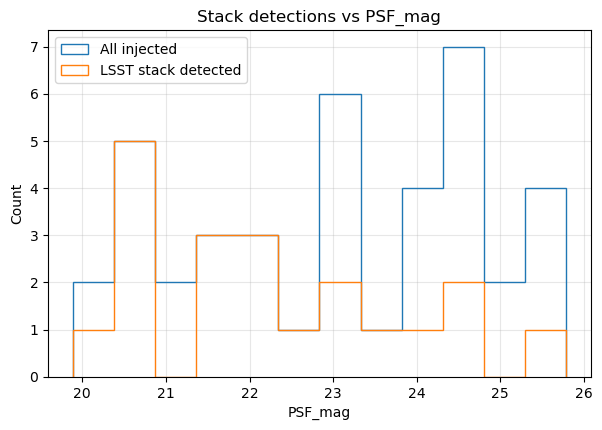

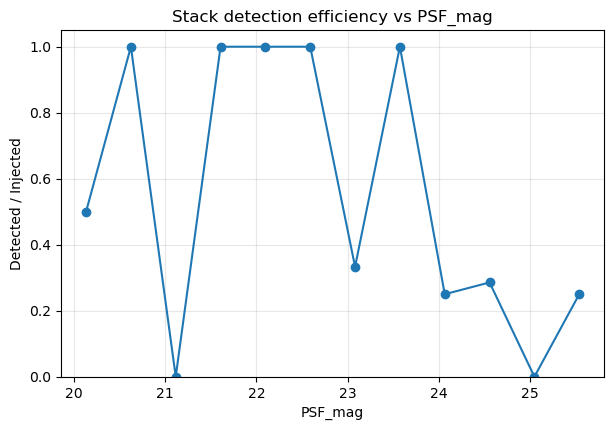

Rows in PSF_mag bin: 5
Stack detected fraction: 1.0


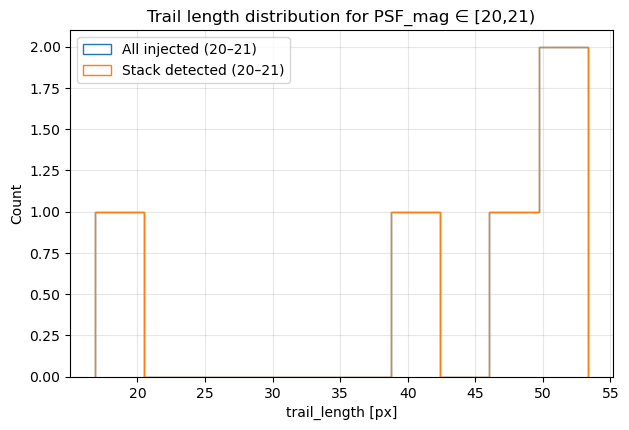

Detected examples: 4 Missed examples: 0


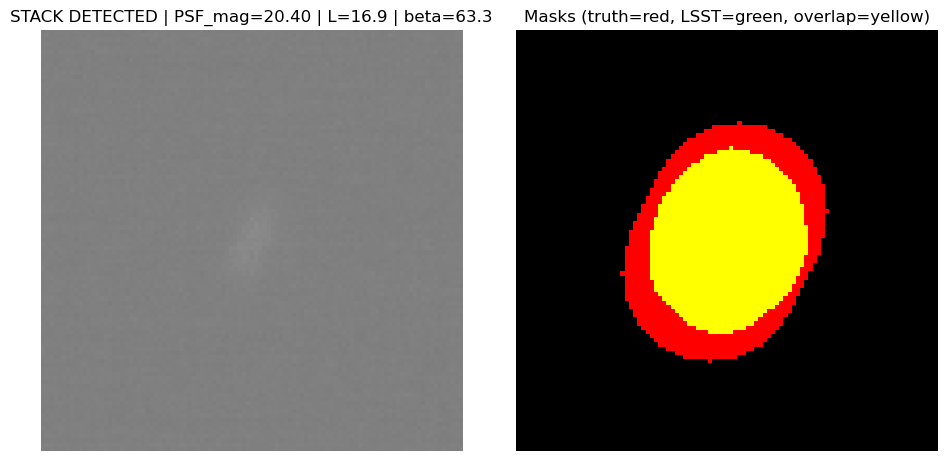

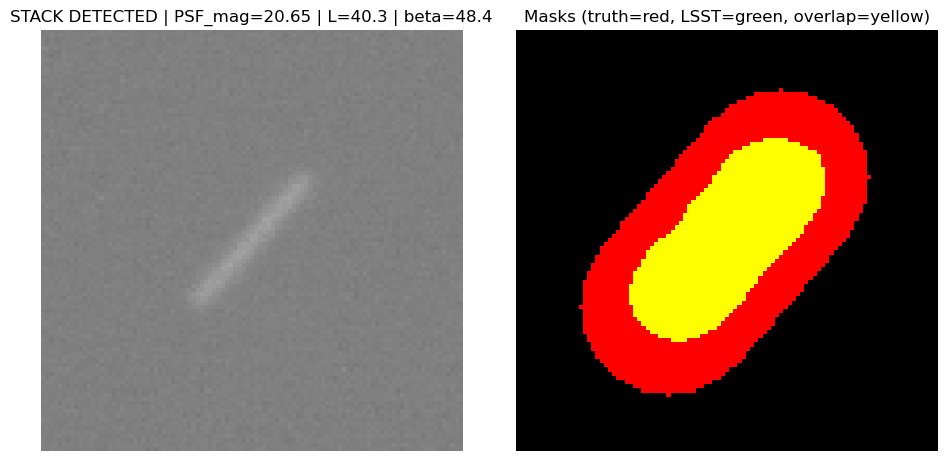

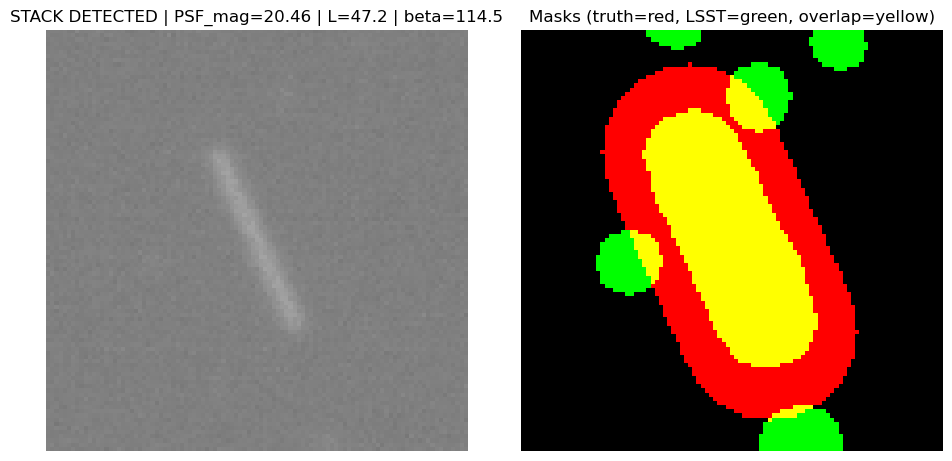

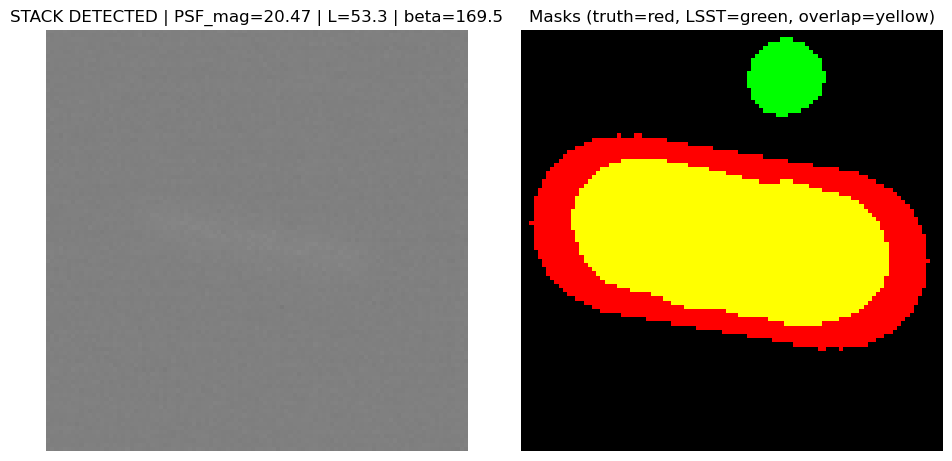

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler

import sys
from pathlib import Path

proj = Path("/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN")

# Make ADCNN importable
sys.path.insert(0, str(proj))

# Make "common.py" (used by simulate_inject.py) importable as a top-level module
#sys.path.insert(0, str(proj / "ADCNN" / "data" / "dataset_creation"))

# Your injection code (adjust import path to where ADCNN is on sys.path)
#from ADCNN.data.dataset_creation.simulate_inject import one_detector_injection

REPO = "/repo/main"
COLL = "LSSTComCam/runs/DRP/DP1/w_2025_03/DM-48478"   # change to your collection
WHERE = ("instrument='LSSTComCam' "
         "AND skymap='lsst_cells_v1' "
         "AND day_obs>=20241101 AND day_obs<=20241127 AND exposure.observation_type='science' AND band in ('u','g','r','i','z','y') "
         "AND (exposure not in (2024110600163, 2024110800318, 2024111200185, 2024111400039, 2024111500225, 2024111500226, 2024111500239, 2024111500240, 2024111500242, "
         "2024111500288, 2024111500289, 2024111800077, 2024111800078, 2024112300230, 2024112400094, 2024112400225, 2024112600327))")

RNG = np.random.default_rng(136)

import logging
logger = logging.getLogger("lsst")
logger.setLevel(logging.ERROR)


butler = Butler(REPO, collections=COLL)
N_detectors=2

# Query dataset refs (calexp)
refs = list(butler.registry.queryDatasets("calexp", where=WHERE, findFirst=True))
refs = sorted(refs, key=lambda r: (int(r.dataId["visit"]), int(r.dataId["detector"])))

print("Total refs:", len(refs))
refs_small = list(RNG.choice(refs, size=min(N_detectors, len(refs)), replace=False))  # start small (e.g. 10–30)
print("Using:", len(refs_small))

# Injection hyperparams (match what you used before)
N_INJECT = 20
TRAIL_LEN = [6, 60]
MAG = [19, 25]         # allow bright/faint; you will later filter 20-21
BETA = [0, 180]
SOURCE_TYPE = "calexp" # keep consistent with your pipeline

dimensions = butler.get("calexp.dimensions", dataId=refs_small[0].dataId)
imgs, masks, cats, source_masks = np.empty((dimensions.y, dimensions.x, len(refs_small))), np.empty((dimensions.y, dimensions.x, len(refs_small))), [], np.empty((dimensions.y, dimensions.x, len(refs_small)))

for k, ref in enumerate(refs_small, 1):
    print ("\r", k, "/", len(refs_small), "done", end="")
    res = one_detector_injection(
        n_inject=N_INJECT,
        trail_length=TRAIL_LEN,
        mag=MAG,
        beta=BETA,
        repo=REPO,
        coll=COLL,
        dimensions=dimensions,
        source_type=SOURCE_TYPE,
        ref_dataId=ref.dataId,
        debug=True)
    if res is None:
        continue

    imgs[:,:,k-1], masks[:,:,k-1], cat, source_masks[:,:,k-1] = res
    df = cat.to_pandas()
    df["image_id"] = k - 1
    # Standardize column name
    if "stack_detection" in df.columns and "stack_detected" not in df.columns:
        df["stack_detected"] = df["stack_detection"].astype(bool)
    cats.append(df)

print("Kept panels:", len(imgs), "total injected rows:", sum(len(d) for d in cats))
cat = pd.concat(cats, ignore_index=True)

def plot_stack_vs_psfmag(cat, bins=12, title="Stack detections vs PSF_mag"):
    field = "PSF_mag"
    vals = cat[field].to_numpy()
    vals = vals[np.isfinite(vals)]
    edges = np.histogram_bin_edges(vals, bins=bins)

    fig, ax = plt.subplots(figsize=(7,4.5))
    ax.hist(cat[field], bins=edges, histtype="step", label="All injected")
    ax.hist(cat.loc[cat["stack_detected"], field], bins=edges, histtype="step", label="LSST stack detected")
    ax.set_xlabel("PSF_mag")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    return fig, ax, edges

fig, ax, edges = plot_stack_vs_psfmag(cat, bins=12)
plt.show()

def plot_stack_efficiency(cat, edges, title="Stack detection efficiency vs PSF_mag"):
    field = "PSF_mag"
    all_counts, _ = np.histogram(cat[field], bins=edges)
    det_counts, _ = np.histogram(cat.loc[cat["stack_detected"], field], bins=edges)
    eff = det_counts / np.maximum(all_counts, 1)

    centers = 0.5*(edges[:-1] + edges[1:])
    fig, ax = plt.subplots(figsize=(7,4.5))
    ax.plot(centers, eff, marker="o")
    ax.set_xlabel("PSF_mag")
    ax.set_ylabel("Detected / Injected")
    ax.set_ylim(0, 1.05)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    return fig, ax

fig, ax = plot_stack_efficiency(cat, edges)
plt.show()

m0, m1 = 20.0, 21.0
sel = cat["PSF_mag"].between(m0, m1, inclusive="left") & np.isfinite(cat["trail_length"])
cat_bin = cat.loc[sel].copy()

print("Rows in PSF_mag bin:", len(cat_bin))
print("Stack detected fraction:", cat_bin["stack_detected"].mean() if len(cat_bin) else np.nan)

def plot_traillen_in_magbin(cat_bin, bins=12, title=None):
    field = "trail_length"
    vals = cat_bin[field].to_numpy()
    edges = np.histogram_bin_edges(vals[np.isfinite(vals)], bins=bins)

    fig, ax = plt.subplots(figsize=(7,4.5))
    ax.hist(cat_bin[field], bins=edges, histtype="step", label="All injected (20–21)")
    ax.hist(cat_bin.loc[cat_bin["stack_detected"], field], bins=edges, histtype="step", label="Stack detected (20–21)")
    ax.set_xlabel("trail_length [px]")
    ax.set_ylabel("Count")
    ax.set_title(title or "Trail length distribution for PSF_mag ∈ [20,21)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    return fig, ax, edges

fig, ax, tl_edges = plot_traillen_in_magbin(cat_bin, bins=10)
plt.show()


def show_cutout(image, truth_mask, lsst_mask, x, y, r=40, title="", st_dev=0):
    x = int(round(x)); y = int(round(y))
    H, W = image.shape
    x0, x1 = max(0, x-r), min(W, x+r+1)
    y0, y1 = max(0, y-r), min(H, y+r+1)

    img_c = image[y0:y1, x0:x1]
    t_c   = truth_mask[y0:y1, x0:x1].astype(bool)
    l_c   = lsst_mask[y0:y1, x0:x1].astype(bool)

    if st_dev == 0:
        vmin, vmax = np.nanpercentile(img_c, [5, 99.5])
    else:
        vmin, vmax = (-st_dev, st_dev)

    # Build RGB composite mask: truth->R, lsst->G, overlap->(R+G)=yellow
    rgb = np.zeros((img_c.shape[0], img_c.shape[1], 3), dtype=float)
    rgb[..., 0] = t_c.astype(float)   # red
    rgb[..., 1] = l_c.astype(float)   # green
    # rgb[..., 2] left as 0 (blue)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9.5, 4.5), constrained_layout=True)

    ax0.imshow(img_c, origin="lower", vmin=vmin, vmax=vmax, cmap="gray")
    ax0.set_title(title if title else "Image")
    ax0.axis("off")

    ax1.imshow(rgb, origin="lower", interpolation="nearest")
    ax1.set_title("Masks (truth=red, LSST=green, overlap=yellow)")
    ax1.axis("off")

    plt.show()

def pick_examples(cat_bin, n_each=3):
    det = cat_bin[cat_bin["stack_detected"]].copy()
    miss = cat_bin[~cat_bin["stack_detected"]].copy()

    # Prefer “representative” examples (middle trail lengths) rather than extremes:
    det = det.sort_values("trail_length")
    miss = miss.sort_values("trail_length")

    det_ex = det.iloc[np.linspace(0, max(len(det)-1,0), num=min(n_each,len(det)), dtype=int)] if len(det) else det
    miss_ex = miss.iloc[np.linspace(0, max(len(miss)-1,0), num=min(n_each,len(miss)), dtype=int)] if len(miss) else miss
    return det_ex, miss_ex

det_ex, miss_ex = pick_examples(cat_bin, n_each=4)

print("Detected examples:", len(det_ex), "Missed examples:", len(miss_ex))

for _, row in det_ex.iterrows():
    img = imgs[:, :, int(row["image_id"])]
    truth_mask = masks[:, :, int(row["image_id"])]
    det_mask = source_masks[:, :, int(row["image_id"])]
    show_cutout(
        img,
        truth_mask=truth_mask,
        lsst_mask=det_mask,
        x=row["x"], y=row["y"],
        r=50,
        title=f"STACK DETECTED | PSF_mag={row['PSF_mag']:.2f} | L={row['trail_length']:.1f} | beta={row['beta']:.1f}",
        st_dev = 5 * np.std(imgs)
    )

for _, row in miss_ex.iterrows():
    img = imgs[:, :, int(row["image_id"])]
    truth_mask = masks[:, :, int(row["image_id"])]
    det_mask = source_masks[:, :, int(row["image_id"])]
    show_cutout(
        img,
        truth_mask=truth_mask,
        lsst_mask=det_mask,
        x=row["x"], y=row["y"],
        r=50,
        title=f"STACK MISSED | PSF_mag={row['PSF_mag']:.2f} | L={row['trail_length']:.1f} | beta={row['beta']:.1f}",
        st_dev = 5 * np.std(imgs)
    )